## Optimizers

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import pdb
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# load data from torchvision module
train_set = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)

test_set = datasets.MNIST(
    root= './data',
    train= False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 256, shuffle= True)


In [5]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= 6, kernel_size= 5, stride= 1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels= 12, kernel_size=5, stride = 1)
        
        self.fc1= nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features= 60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
         # first hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size= 2, stride= 2)
        
        # second hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size= 2, stride= 2)
        
        # first linear layer 
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        #second linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        #output layer
        t = self.out(t)
        #ideally here we would use softmax function but since we are going to use cross entropy loss, softmax
        # is not explicitly required 
        
        return F.log_softmax(t, dim= 1)

### Vanilla SGD

In [6]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()
lr = 0.01
#weights = [(child.weight.data, child.bias.data) for child in net.children()]

for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        #weights = [(child.weight.data, child.bias.data) for child in net.children()]
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        
        for child in net.children():
            child.weight.data -= lr * child.weight.grad.data
            child.bias.data -= lr * child.bias.grad.data
        
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            child.weight.grad.data.zero_()
            child.bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [7]:
sgd_losses_ = [(l.data.item()) for l in losses]
sgd_log_losses_ = [np.log(l) for l in sgd_losses_]

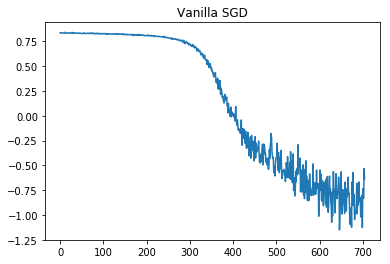

In [8]:
plt.plot(sgd_log_losses_)
title = plt.title("Vanilla SGD")

### SGD with Momentum

In [9]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001
gamma = 0.9
weight_v_prev = [0 for i in range(5)]
bias_v_prev = [0 for i in range(5)]


for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        #weights = [(child.weight.data, child.bias.data) for child in net.children()]
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(weight_v_prev)):
            
            #print("Gradients\n" ,children[i].weight.grad.data)
            weight_v_new = gamma * weight_v_prev[i] + lr * children[i].weight.grad.data
            bias_v_new = gamma * bias_v_prev[i] + lr * children[i].bias.grad.data
            
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            children[i].weight.data -= weight_v_new
            children[i].bias.data -= bias_v_new
            
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [10]:
sgdmom_losses_ = [(l.data.numpy()) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

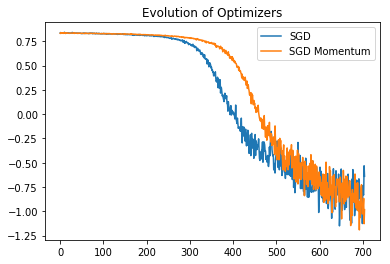

In [11]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum'))

### Nesterov

In [12]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001
gamma = 0.9
weight_v_prev = [0 for i in range(5)]
bias_v_prev = [0 for i in range(5)]


for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        #weights = [(child.weight.data, child.bias.data) for child in net.children()]
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        
        for i in range(len(weight_v_prev)):
            
            #update WEIGHT
            # take a step ahead in momentum direction
            original_weight = children[i].weight.data
            children[i].weight.data -= gamma * weight_v_prev[i]
            
            #calculate loss and gradients 
            future_outputs = net(images)
            future_loss = criterion(future_outputs, labels)
            future_loss.backward(retain_graph = True)
            future_grad = children[i].weight.grad.data
            
            weight_v_new = gamma * weight_v_prev[i] + lr * future_grad
            weight_v_prev[i] = weight_v_new
            
            children[i].weight.data = original_weight
            children[i].weight.data -= weight_v_new
            
            #zero the gradients so that gradients dont get accumulate
            net.zero_grad()
            #children[i].weight.grad.data.zero_()
            
            
            #update BIAS
            original_bias = children[i].bias.data
            children[i].bias.data -= gamma * bias_v_prev[i]
            
            #calculate loss and gradients 
            future_outputs = net(images)
            future_loss = criterion(future_outputs, labels)
            future_loss.backward(retain_graph = True)
            future_grad = children[i].bias.grad.data
            
            bias_v_new = gamma * bias_v_prev[i] + lr * future_grad
            bias_v_prev[i] = bias_v_new
            
            children[i].bias.data = original_bias
            children[i].bias.data -= bias_v_new
            
            #zero the gradients so that gradients dont get accumulate
            net.zero_grad()
            

epoch 0
epoch 1
epoch 2


In [13]:
nesterov_losses_ = [(l.data.numpy()) for l in losses]
nesterov_log_losses_ = [np.log(l) for l in nesterov_losses_]

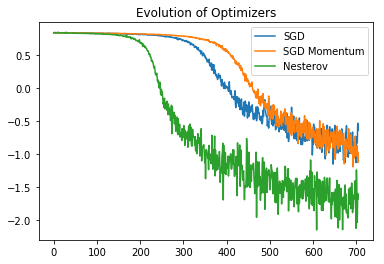

In [14]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov'))

### Adagrad

In [37]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001

children = list(net.children())
cache_weight = [torch.zeros(child.weight.size()) for child in net.children()]
cache_bias=   [torch.zeros(child.bias.size()) for child in net.children()]

epsilon = 1e-8

for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        
        #print("New batch {} \n\n".format(idx))
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(children)):
            
            #update cache
            cache_weight[i].data += children[i].weight.grad.data ** 2
            cache_bias[i].data += children[i].bias.grad.data ** 2
            
            #update weights
            children[i].weight.data -= lr * children[i].weight.grad.data / torch.sqrt(cache_weight[i] + epsilon)
            children[i].bias.data -= lr * children[i].bias.grad.data / torch.sqrt(cache_bias[i] + epsilon)
        
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [38]:
adagrad_losses_ = [(l.data.numpy()) for l in losses]
adagrad_log_losses_ = [np.log(l) for l in adagrad_losses_]

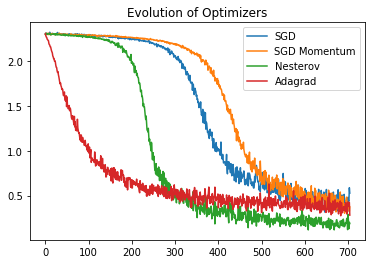

In [39]:
plt.plot(sgd_losses_)
plt.plot(sgdmom_losses_)
plt.plot(nesterov_losses_)
plt.plot(adagrad_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad'))

### RMSprop

In [18]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001

children = list(net.children())
cache_weight = [torch.zeros(child.weight.size()) for child in net.children()]
cache_bias=   [torch.zeros(child.bias.size()) for child in net.children()]
epsilon = 1e-8
rho = 0.9

for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(children)):
            
            #update cache
            cache_weight[i].data = rho * cache_weight[i].data + (1-rho) * children[i].weight.grad.data ** 2
            cache_bias[i].data =  rho * cache_bias[i].data + (1-rho) *children[i].bias.grad.data ** 2
            
            #update weights
            children[i].weight.data -= lr * children[i].weight.grad.data / torch.sqrt(cache_weight[i] + epsilon)
            children[i].bias.data -= lr * children[i].bias.grad.data / torch.sqrt(cache_bias[i] + epsilon)
            
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [19]:
rmsprop_losses_ = [(l.data.numpy()) for l in losses]
rmsprop_log_losses_ = [np.log(l) for l in rmsprop_losses_]

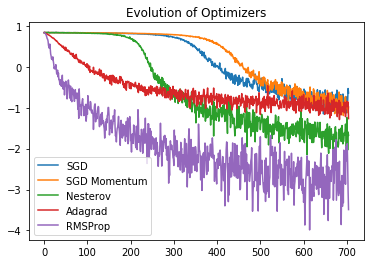

In [40]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp'))

### Adam

In [21]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001

children = list(net.children())

weight_v_prev = [torch.zeros(child.weight.size()) for child in net.children()]
bias_v_prev = [torch.zeros(child.bias.size()) for child in net.children()]

cache_weight = [torch.zeros(child.weight.size()) for child in net.children()]
cache_bias=   [torch.zeros(child.bias.size()) for child in net.children()]
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999

t= 0
for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        
        t += 1
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(children)):
            
            weight_v_new = beta1 * weight_v_prev[i] + (1-beta1) * children[i].weight.grad.data
            bias_v_new = beta1 * bias_v_prev[i] + (1-beta1) * children[i].bias.grad.data
            weight_v_new_hat = weight_v_new/ (1- beta1 ** t)
            bias_v_new_hat = bias_v_new/ (1- beta1**t)
            
            cache_weight_new = beta2 * cache_weight[i].data + (1-beta2) * (children[i].weight.grad.data ** 2)
            cache_bias_new =  beta2 * cache_bias[i].data + (1-beta2) * (children[i].bias.grad.data ** 2)
            cache_weight_hat = cache_weight_new/(1-beta2 ** t)
            cache_bias_hat = cache_bias_new/(1-beta2**t)
            
            #update momentum terms
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            #update cache
            cache_weight[i] = cache_weight_new
            cache_bias[i] = cache_bias_new
        
            #update weights
            children[i].weight.data -= lr * weight_v_new_hat / torch.sqrt(cache_weight_hat + epsilon)
            children[i].bias.data -= lr * bias_v_new_hat / torch.sqrt(cache_bias_hat + epsilon)
        
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [22]:
adam_losses_ = [(l.data.numpy()) for l in losses]
adam_log_losses_ = [np.log(l) for l in adam_losses_]

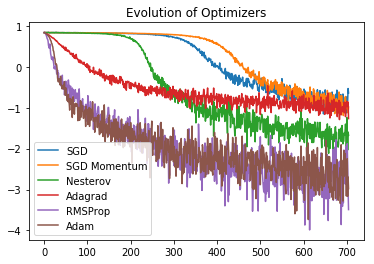

In [41]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
plt.plot(adam_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp', 'Adam'))

### AdaMax

In [24]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001

children = list(net.children())

weight_v_prev = [torch.zeros(child.weight.size()) for child in net.children()]
bias_v_prev = [torch.zeros(child.bias.size()) for child in net.children()]

cache_weight = [torch.zeros(child.weight.size()) for child in net.children()]
cache_bias=   [torch.zeros(child.bias.size()) for child in net.children()]
epsilon = 1e-22
beta1 = 0.9
beta2 = 0.999

t= 0
for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        
        t += 1
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(children)):
            
            weight_v_new = beta1 * weight_v_prev[i] + (1-beta1) * children[i].weight.grad.data
            bias_v_new = beta1 * bias_v_prev[i] + (1-beta1) * children[i].bias.grad.data
            weight_v_new_hat = weight_v_new/ (1- beta1 ** t)
            bias_v_new_hat = bias_v_new/ (1- beta1**t)
            
            cache_weight_new = torch.max(beta2 * cache_weight[i].data ,torch.abs(children[i].weight.grad.data))
            cache_bias_new =  torch.max(beta2 * cache_bias[i].data, torch.abs(children[i].bias.grad.data))
            
            
            #update momentum terms
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            #update cache
            cache_weight[i] = cache_weight_new
            cache_bias[i] = cache_bias_new
        
            #update weights
            children[i].weight.data -= lr * weight_v_new_hat / torch.sqrt(cache_weight_new + epsilon)
            children[i].bias.data -= lr * bias_v_new_hat / torch.sqrt(cache_bias_new + epsilon)
        
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [25]:
adamax_losses_ = [(l.data.numpy()) for l in losses]
adamax_log_losses_ = [np.log(l) for l in adamax_losses_]

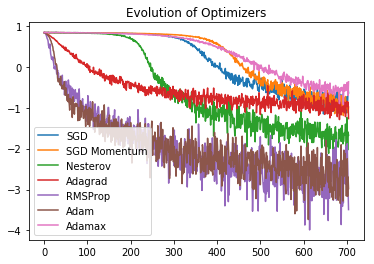

In [42]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
plt.plot(adam_log_losses_)
plt.plot(adamax_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp', 'Adam', 'Adamax'))

### NAdam

In [27]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001

children = list(net.children())

weight_v_prev = [torch.zeros(child.weight.size()) for child in net.children()]
bias_v_prev = [torch.zeros(child.bias.size()) for child in net.children()]

cache_weight = [torch.zeros(child.weight.size()) for child in net.children()]
cache_bias=   [torch.zeros(child.bias.size()) for child in net.children()]
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999

t= 0
for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        
        t += 1
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(children)):
            
            weight_v_new = beta1 * weight_v_prev[i] + (1-beta1) * children[i].weight.grad.data
            bias_v_new = beta1 * bias_v_prev[i] + (1-beta1) * children[i].bias.grad.data
            weight_v_new_hat = weight_v_new/ (1- beta1 ** t)
            bias_v_new_hat = bias_v_new/ (1- beta1**t)
            
            cache_weight_new = beta2 * cache_weight[i].data + (1-beta2) * (children[i].weight.grad.data ** 2)
            cache_bias_new =  beta2 * cache_bias[i].data + (1-beta2) * (children[i].bias.grad.data ** 2)
            cache_weight_hat = cache_weight_new/(1-beta2 ** t)
            cache_bias_hat = cache_bias_new/(1-beta2**t)
            
            #update momentum terms
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            #update cache
            cache_weight[i] = cache_weight_new
            cache_bias[i] = cache_bias_new
        
            #update weights
            children[i].weight.data -= lr * ((beta1 * weight_v_new_hat) + ((1-beta1)*children[i].weight.grad.data)/(1-beta1**t)) / torch.sqrt(cache_weight_hat + epsilon)
            children[i].bias.data -= lr * ((beta1 * bias_v_new_hat) + ((1-beta1)*children[i].bias.grad.data)/(1-beta1**t)) / torch.sqrt(cache_bias_hat + epsilon)
        
            #zero the gradients so that gradients dont get accumulate
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [28]:
nadam_losses_ = [(l.data.numpy()) for l in losses]
nadam_log_losses_ = [np.log(l) for l in nadam_losses_]

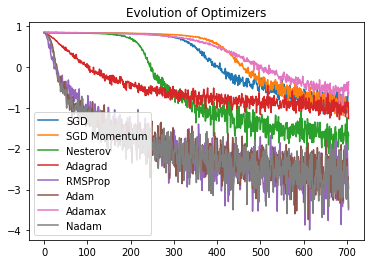

In [43]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
plt.plot(adam_log_losses_)
plt.plot(adamax_log_losses_)
plt.plot(nadam_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp', 'Adam', 'Adamax', 'Nadam'))

### AMSGrad

In [30]:
##train
net = Network()
net.to(device)

epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function
losses = []
net.train()

lr = 0.001

children = list(net.children())

weight_v_prev = [torch.zeros(child.weight.size()) for child in net.children()]
bias_v_prev = [torch.zeros(child.bias.size()) for child in net.children()]

cache_weight = [torch.zeros(child.weight.size()) for child in net.children()]
cache_bias=   [torch.zeros(child.bias.size()) for child in net.children()]
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999

t= 0
for epoch in range(epochs):
    print('epoch {}'.format(epoch))
    for idx, (images, labels) in enumerate(train_loader):
        
        t += 1
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        losses.append(loss)
        loss.backward()
        
        children = list(net.children())
        
        #update weights
        for i in range(len(children)):
            
            weight_v_new = beta1 * weight_v_prev[i] + (1-beta1) * children[i].weight.grad.data
            bias_v_new = beta1 * bias_v_prev[i] + (1-beta1) * children[i].bias.grad.data
            weight_v_new_hat = weight_v_new/ (1- beta1 ** t)
            bias_v_new_hat = bias_v_new/ (1- beta1**t)
            
            cache_weight_new = beta2 * cache_weight[i].data + (1-beta2) * (children[i].weight.grad.data ** 2)
            cache_bias_new =  beta2 * cache_bias[i].data + (1-beta2) * (children[i].bias.grad.data ** 2)
            cache_weight_hat = torch.max(cache_weight[i], torch.abs(cache_weight_new))
            cache_bias_hat = torch.max(cache_bias[i], torch.abs(cache_bias_new))
            
            #update momentum terms
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            #update cache
            cache_weight[i] = cache_weight_hat
            cache_bias[i] = cache_bias_hat
        
            #update weights
            children[i].weight.data -= lr * weight_v_new_hat / torch.sqrt(cache_weight_hat + epsilon)
            children[i].bias.data -= lr * bias_v_new_hat / torch.sqrt(cache_bias_hat + epsilon)
        
            #zero the gradients so that gradients dont get accumulate
            #print("set gradients zero")
            children[i].weight.grad.data.zero_()
            children[i].bias.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [31]:
amsgrad_losses_ = [(l.data.numpy()) for l in losses]
amsgrad_log_losses_ = [np.log(l) for l in amsgrad_losses_]

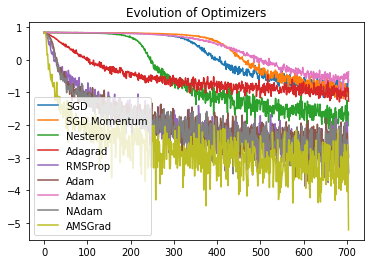

In [44]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
plt.plot(adam_log_losses_)
plt.plot(adamax_log_losses_)
plt.plot(nadam_log_losses_)
plt.plot(amsgrad_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp', 'Adam', 'Adamax', 'NAdam', 'AMSGrad'))